# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW08] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [2]:
def gini(x: np.ndarray) -> float:
    """
    Считает коэффициент Джини для массива меток x.
    """
    labels = np.unique(x)
    res = 0
    for y in labels:
        p = np.sum(x == y) / x.shape[0]
        res += p * (1 - p)
    return res

def entropy(x: np.ndarray) -> float:
    """
    Считает энтропию для массива меток x.
    """
    labels = np.unique(x)
    res = 0
    for y in labels:
        p = np.sum(x == y) / x.shape[0]
        res -= p * np.log(p)
    return res

def gain(all_y: np.ndarray, left_y: np.ndarray, right_y: np.ndarray, criterion: str) -> float:
    """
    Считает информативность разбиения массива меток.

    Parameters
    ----------
    left_y : np.ndarray
        Левая часть разбиения.
    right_y : np.ndarray
        Правая часть разбиения.
    criterion : Callable
        Критерий разбиения.
    """
    if criterion == 'gini':
        foo = gini
    else:
        foo = entropy
    return all_y.shape[0] * foo(all_y) - (left_y.shape[0] * foo(left_y) + right_y.shape[0] * foo(right_y)) / (all_y).shape[0]

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__

In [3]:
class DecisionTreeLeaf:
    """

    Attributes
    ----------
    y : Тип метки (напр., int или str)
        Метка класса, который встречается чаще всего среди элементов листа дерева
    """
    def __init__(self, labels):
        self.prob_distribution = {}
        uniq_labels = np.unique(labels)
        for x in uniq_labels:
            self.prob_distribution[x] = (np.sum(labels==x) / len(labels))
        self.y = uniq_labels[np.argmax(list(self.prob_distribution.values()))]


class DecisionTreeNode:
    """

    Attributes
    ----------
    split_dim : int
        Измерение, по которому разбиваем выборку.
    split_value : float
        Значение, по которому разбираем выборку.
    left : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] < split_value.
    right : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] >= split_value. 
    """
    def __init__(self, split_dim: int, split_value: float, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (3 балла)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [4]:
class DecisionTreeClassifier:
    """
    Attributes
    ----------
    root : Union[DecisionTreeNode, DecisionTreeLeaf]
        Корень дерева.

    (можете добавлять в класс другие аттрибуты).

    """
    def __init__(self, criterion : str = "gini", 
                 max_depth : Optional[int] = None, 
                 min_samples_leaf: int = 1):
        """
        Parameters
        ----------
        criterion : str
            Задает критерий, который будет использоваться при построении дерева.
            Возможные значения: "gini", "entropy".
        max_depth : Optional[int]
            Ограничение глубины дерева. Если None - глубина не ограничена.
        min_samples_leaf : int
            Минимальное количество элементов в каждом листе дерева.

        """
        self.root = None
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.X = None
        self.labels = None

##############################################

    def build_tree(self, X: np.array, y: np.array, cur_depth):
        if cur_depth >= self.max_depth or np.unique(y).shape[0] == 1\
                or X.shape[0] < 2 * self.min_samples_leaf:
            return DecisionTreeLeaf(y)
        max_gain = 0
        split_feature = None
        split_value = None
        split_i = None
        X_ = np.argsort(X, axis=0)
        gain_list = []
        for feature in range(X.shape[1]):
            index = X_[:, feature]    # индексы векторов, отсортированных по возрастанию фичи feature
            for i in range(self.min_samples_leaf, X.shape[0] - self.min_samples_leaf + 1):
                left_y = y[index[:i]]
                right_y = y[index[i:]]
                cur_gain = gain(y[index], left_y, right_y, self.criterion)
                gain_list.append(cur_gain)
                if max_gain < cur_gain:
                    max_gain = cur_gain
                    split_feature = feature
                    # split_value = (X[index[i], feature] + X[index[i+1], feature]) / 2
                    split_value = X[index[i+1], feature]
                    split_i = i
        # print('gane:', max_gain)
        # print('split_feature:', split_feature, 'split_value:', split_value, 'split_i:', split_i)
        # print(gain_list)
        if max_gain == 0:
            return DecisionTreeLeaf(y)
        split_index = X_[:, split_feature]
        left_node = self.build_tree(X[split_index][:split_i].copy(), y[split_index][:split_i].copy(), cur_depth + 1)
        right_node = self.build_tree(X[split_index][split_i:].copy(), y[split_index][split_i:].copy(), cur_depth + 1)
        return DecisionTreeNode(split_feature, split_value, left_node, right_node)




    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Строит дерево решений по обучающей выборке.

        Parameters
        ----------
        X : np.ndarray
            Обучающая выборка.
        y : np.ndarray
            Вектор меток классов.
        """
        self.root = self.build_tree(X, y, 0)


    def go(self, node, x):
        if isinstance(node, DecisionTreeLeaf):
            return node.prob_distribution
        if x[node.split_dim] < node.split_value:
            return self.go(node.left, x)
        return self.go(node.right, x)

    def predict_proba(self, X: np.ndarray) ->  List[Dict[Any, float]]:
        """
        Предсказывает вероятность классов для элементов из X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.
        
        Return
        ------
        List[Dict[Any, float]]
            Для каждого элемента из X возвращает словарь 
            {метка класса -> вероятность класса}.
        """
        res = []
        for x in X:
            res.append(self.go(self.root, x))
        return res

    
    def predict(self, X : np.ndarray) -> list:
        """
        Предсказывает классы для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.
        
        Return
        ------
        list
            Вектор предсказанных меток для элементов X.
        """
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [5]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [6]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Наконец, протестируем дерево решений на синтетических наборах данных.

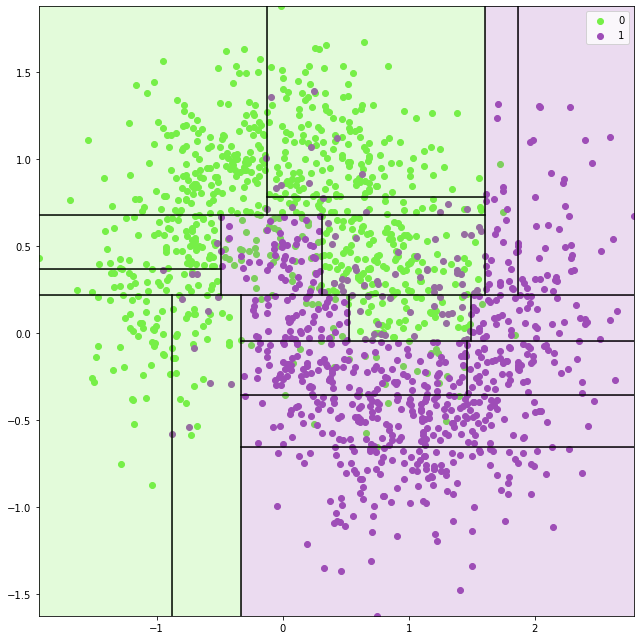

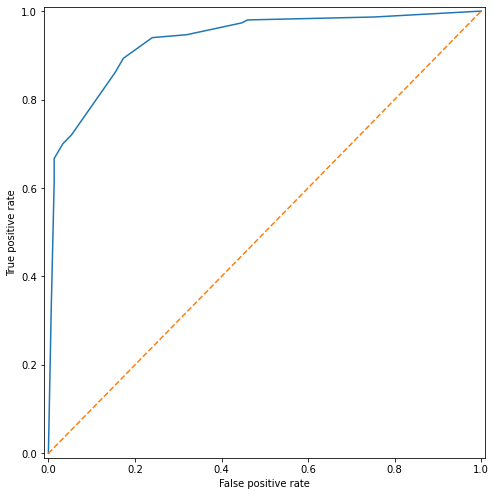

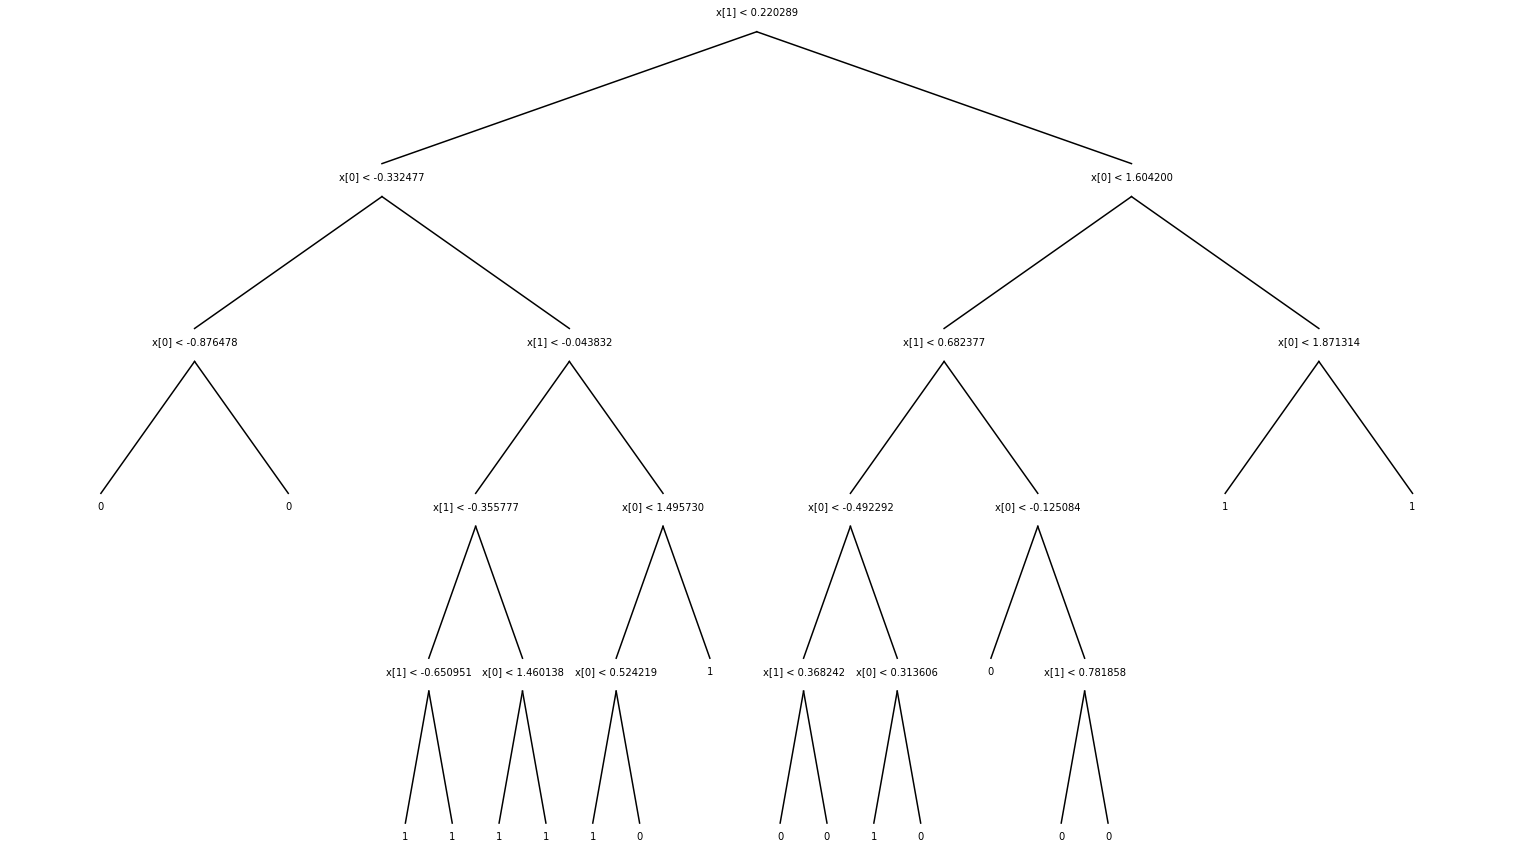

In [7]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(300, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

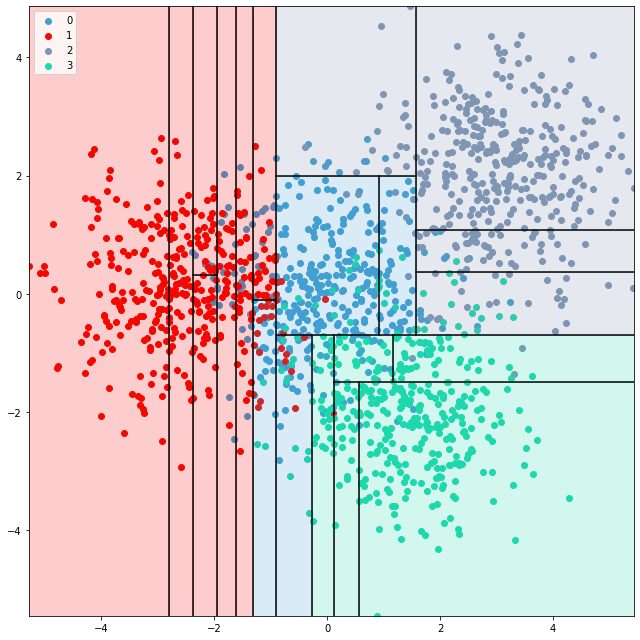

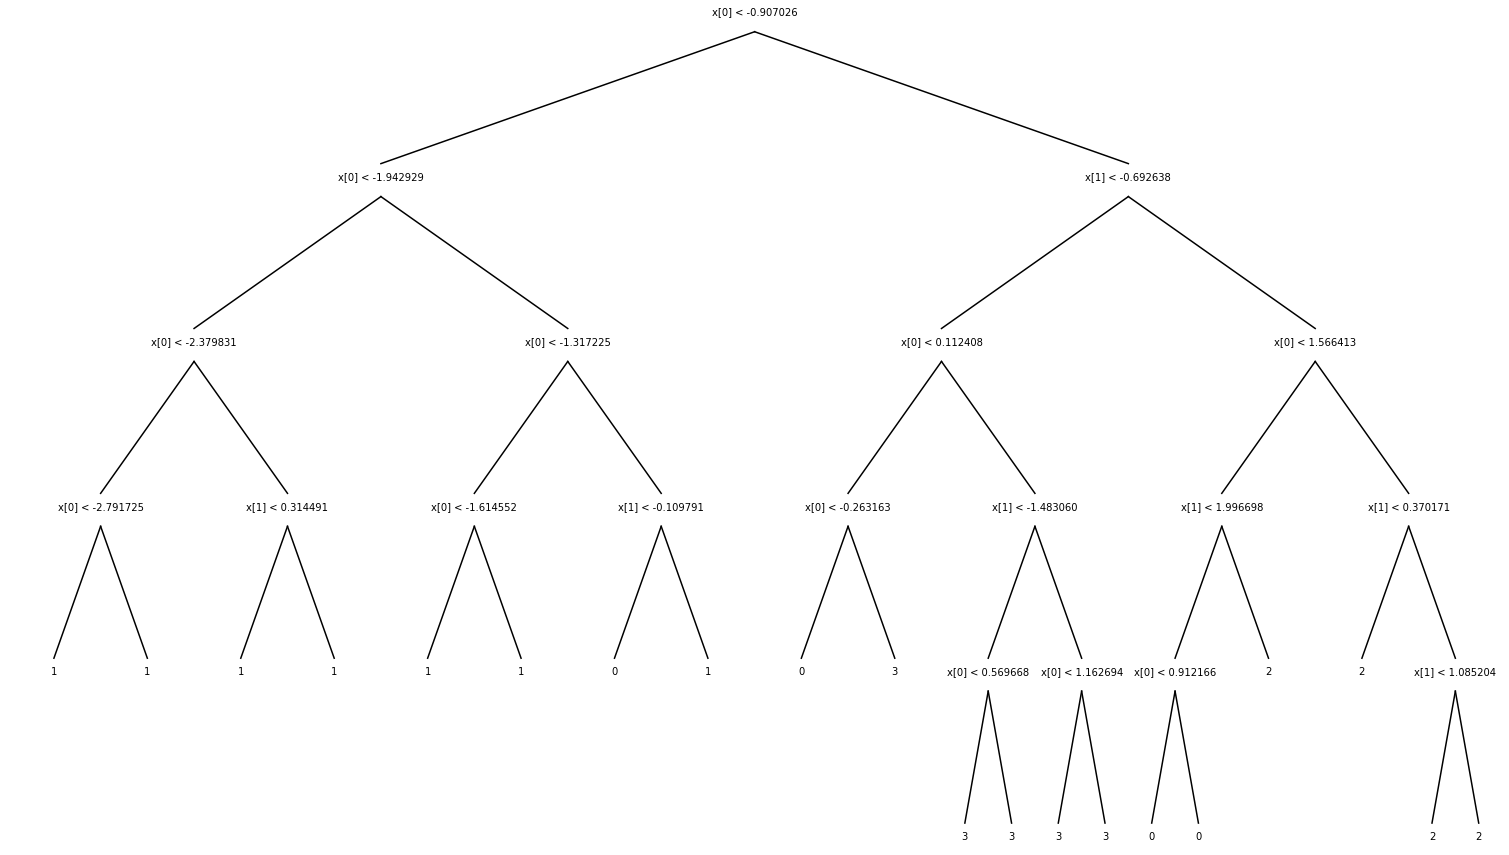

In [16]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Задание 4 (3 балла)
У малоизвестной MMORPG Smash Art Online удалилась часть базы данных, а бэкапа не оказалось. Уволив сисадмина, тимлид начал думать, как проще и быстрее разрешить ситуацию. Оказалось, что в основном пострадала информация о классах персонажей, но зато часть внутриигровой статистики осталась нетронутой. Было решено не перезапускать игровой мир, а попробовать восстановить утерянные данные.

Посчитав, что ручное восстановление классов персонажей было бы очень долгим и вызвало бы недовольство игроков, тимлид решил пригласить специалиста по машинному обучению, который смог бы восстановить большую часть данных автоматически. 

Ваша задача - построить дерево решений, которое как можно более точно восстанавливает класс персонажа. В этом вам поможет статистика персонажей, а так же сохранившаяся часть классов персонажей. Чтобы дерево было достаточно интерпретируемым, его высота должна быть не больше `6`.


#### Оценка задания
Баллы за это задание выставляются в зависимости от точности полученного классификатора на закрытой части выборки:
1. __Точность > 50%__ - 1 балл - классификатор значительно облегчил команде игры задачу по восстановлению классов игроков. Тимлид доволен и, вероятно, захочет продолжить сотрудничество в дальнейшем
2. __Точность > 85%__ - 3 балла - классификатор сделал большую часть работы. Довольный тимлид задумчиво чешет подбородок, а затем предлагает сотрудничество на постоянной основе

__Важно: метки классов - названия, а не числа. Пусть так и остается.__

In [9]:
def read_dataset_custum(dataset, alpha=0.8):
    random.shuffle(dataset)
    N = int(len(dataset) * alpha)
    y_train = [row[0] for row in dataset[:N]]
    X_train = [row[1:] for row in dataset[:N]]
    y_test = [row[0] for row in dataset[N:]]
    X_test = [row[1:] for row in dataset[N:]]
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [10]:
%%time
n = 10
depths = [3, 4, 5, 6]
leafs = [10, 15, 16, 20, 25, 30, 35, 40]

dataframe = pandas.read_csv('/content/train.csv', header=1)
dataset = dataframe.values.tolist()

def mean_acc(dataset, depth, leaf):
    acc_list = []
    for i in range(n):
        X_train, y_train, X_test, y_test = read_dataset_custum(dataset)
        dtc = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)
        dtc.fit(X_train, y_train)
        y_pred = dtc.predict(X_test)
        acc_list.append(np.sum(y_test == y_pred) / y_test.shape[0])
    return np.mean(acc_list)


def best_param():
    table = np.zeros((len(depths), len(leafs)))
    for i in range(len(depths)):
        for j in range(len(leafs)):
            table[i, j] = mean_acc(dataset, depths[i], leafs[j])
    print(table, '\n')
    print(f'best is {np.max(table)}')
    for i in range(len(depths)):
        for j in range(len(leafs)):
            if table[i , j] == np.max(table):
                return depths[i], leafs[j]

depth, leaf = best_param()
print(f'best depth={depth} and leaf_size={leaf}')

[[0.85       0.83083333 0.82583333 0.84666667 0.8125     0.8375
  0.84083333 0.785     ]
 [0.875      0.835      0.83       0.82666667 0.81333333 0.8375
  0.81333333 0.82916667]
 [0.88916667 0.85416667 0.8475     0.84166667 0.8225     0.80333333
  0.82416667 0.79666667]
 [0.86333333 0.86166667 0.86166667 0.83916667 0.80333333 0.805
  0.80833333 0.815     ]] 

best is 0.8891666666666668
best depth=5 and leaf_size=10
CPU times: user 5min 13s, sys: 835 ms, total: 5min 14s
Wall time: 5min 22s


Теперь при лучших параметрах обучим модель

In [11]:
def read_dataset(path):
    dataframe = pandas.read_csv(path, header=1)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y)

X, y = read_dataset("/content/train.csv")
dtc = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)
dtc.fit(X, y)

### Задание 5 (1 балл)
От игроков начали поступать жалобы на то, что класс их персонажа внезапно сменился. В таких случаях модераторы смотрят на данные персонажа и пытаются восстановить его класс сами. Для того, чтобы им было проще это сделать, нужно научиться для каждого персонажа объяснять, почему дерево решений присвоило персонажу именно такой класс.

Реализуйте функцию `predict_explain(dtc, X)`. Для каждого элемента элемента набора данных `X` она должна вернуть пару из предсказанного класса и человекочетаемой строковой записи условий, благодаря которым был предсказан класс. 

In [12]:
def go_and_explain(node, x):
    '''
    функция для последнего задания
    '''
    if isinstance(node, DecisionTreeLeaf):
        return []
    if x[node.split_dim] < node.split_value:
        s = f'x[{node.split_dim}] < {node.split_value:.3f}'
        return [s] + go_and_explain(node.left, x)
    s = f'x[{node.split_dim}] >= {node.split_value:.3f}'
    return [s] + go_and_explain(node.right, x)

def predict_explain(dtc: DecisionTreeClassifier, X: np.ndarray):
    pred_y = dtc.predict(X)
    ans = []
    for i in range(X.shape[0]):
        s = ', '.join(map(str, go_and_explain(dtc.root, X[i])))
        ans.append((pred_y[i], s))
    return ans

In [13]:
X, y = read_dataset("/content/train.csv")
for pred_y, expl in predict_explain(dtc, X[:3]):
    print("Class:", pred_y)
    print("Explanation:", expl)
    print()


Class: warrior
Explanation: x[1] >= 0.351, x[1] < 0.917, x[3] < 0.843, x[2] < 3.687, x[1] >= 0.489

Class: rogue
Explanation: x[1] >= 0.351, x[1] < 0.917, x[3] >= 0.843, x[0] >= 1.276

Class: warrior
Explanation: x[1] < 0.351, x[2] < 0.656, x[0] >= 2.122

